In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils import get_device, train_clf, eval_clf, test_clf
from RoBertaClassifier import RoBertaClassifier, init_roberta_clf

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [5]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskA_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,La CNN ha appena ammesso che Trump non è più a...
1,1,"Notizia del 2017: “Autovelox, la foto viola la..."
2,2,"La foto di due ""sospetti"" in un palazzo non è ..."
3,3,La falsa notizia della bambina con il cartello...
4,4,Ah dimenticavo.. e' gratuita


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            460 non-null    int64 
 1   comment_text  460 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


## Preprocessing

Remove break line characthers

In [8]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))

## Train-Validation split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [10]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [11]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1509 to 1768
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1473 non-null   int64 
 1   comment_text    1473 non-null   object
 2   conspiratorial  1473 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.0+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [12]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 361 to 667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              369 non-null    int64 
 1   comment_text    369 non-null    object
 2   conspiratorial  369 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.5+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [13]:
from transformers import AutoTokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [15]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

texts_test = texts_df_test['comment_text']

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


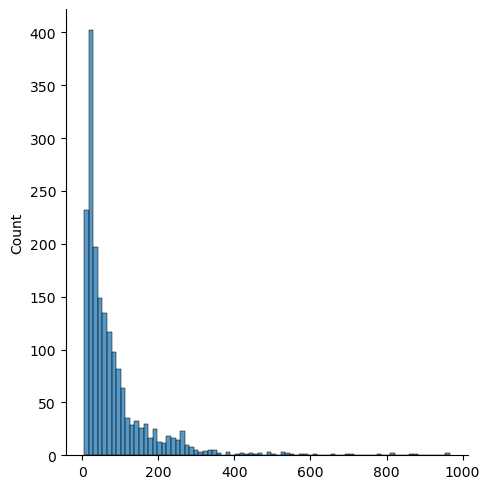

In [16]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the RoBERTa max_lenght limit of 512. For memory constraints we will use a max_lenght of 256. Also most texts are shorter than 256 tokens.

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []
max_sentence_len = 256

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens
for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

# Test set
input_ids_test = []
attention_masks_test = []

for sentence in texts_test:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

In [18]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)
input_ids_test = torch.cat(input_ids_test, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [20]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

The DataLoader needs to know our batch size for training. For mameory constraints, we use a lower batch size of 6.

In [21]:
batch_size = 6

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [22]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

## Training Grid Search

In [23]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

Set save folder for this run

In [25]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_roberta_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-28 03:00:09.097023


Fixed general hyperparams

In [26]:
max_epochs = 12

# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs
warmup_steps = 0.05*tr_steps

Variable grid searched hyperparams (smaller grid search because of time and size constraints)

In [27]:
lr_list = [6e-6, 8e-6]
clf_head_list = []

head2 = nn.Sequential(
                nn.Linear(1024, 768),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(768, 2),
                )
clf_head_list.append((head2, '2_layers_L')) # Each head obeject is composed by a tuple (head, name)

head3 = nn.Sequential(
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 2),
                )
clf_head_list.append((head3, '3_layers_L'))

Initialize, train/eval and save function for each grid search run

In [28]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth, device):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    roberta_clf_model, loss_function, optimizer, scheduler = init_roberta_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, roberta_clf_model, optimizer, scheduler = train_clf(roberta_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(roberta_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'roberta_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': roberta_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [29]:
num_trials = len(lr_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:            
            # Model save path subfolder
            model_folder_str = 'lr{}_head_{}'.format(lr, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, head={}'.format(lr, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth, device=device)

Executing 4 trials in grid search

Executing model with lr=6e-06, head=2_layers_L


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6551721425560432 - Tr acc: 0.5906313645621182 - Tr f1: 0.5809404152668038
EVALUATION | Val Loss: 0.5767035046892781 - Val acc: 0.6964769647696477 - Val f1: 0.6854794520547945
Epoch: 1
TRAINING | Tr Loss: 0.5120029712050427 - Tr acc: 0.7705363204344874 - Tr f1: 0.7703914479145528
EVALUATION | Val Loss: 0.5045907380840471 - Val acc: 0.7506775067750677 - Val f1: 0.7405221964045494
Epoch: 2
TRAINING | Tr Loss: 0.41328261532192306 - Tr acc: 0.8445349626612356 - Tr f1: 0.8445338162236204
EVALUATION | Val Loss: 0.6045002940922014 - Val acc: 0.7642276422764228 - Val f1: 0.7635329733870553
Epoch: 3
TRAINING | Tr Loss: 0.35951060978591637 - Tr acc: 0.9056347589952478 - Tr f1: 0.9056262338484825
EVALUATION | Val Loss: 1.0128829096830751 - Val acc: 0.7940379403794038 - Val f1: 0.7940001175295293
Epoch: 4
TRAINING | Tr Loss: 0.2579552659471955 - Tr acc: 0.9416157501697217 - Tr f1: 0.9416135704962278
EVALUATION | Val Loss: 1.2803082587535404 - Val acc: 0.77506775067750

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.682431749333211 - Tr acc: 0.560081466395112 - Tr f1: 0.55832083958021
EVALUATION | Val Loss: 0.6609041013063923 - Val acc: 0.6070460704607046 - Val f1: 0.5785182559376107
Epoch: 1
TRAINING | Tr Loss: 0.6134811810603956 - Tr acc: 0.6768499660556687 - Tr f1: 0.6760974329787942
EVALUATION | Val Loss: 0.5706925014815023 - Val acc: 0.7289972899728997 - Val f1: 0.7282768777614138
Epoch: 2
TRAINING | Tr Loss: 0.4937404431402683 - Tr acc: 0.7739307535641547 - Tr f1: 0.7737100672490891
EVALUATION | Val Loss: 0.5394856893727856 - Val acc: 0.7750677506775068 - Val f1: 0.7739454552164446
Epoch: 3
TRAINING | Tr Loss: 0.4244584733150839 - Tr acc: 0.8472505091649695 - Tr f1: 0.84722234386762
EVALUATION | Val Loss: 0.6366605889052153 - Val acc: 0.7696476964769647 - Val f1: 0.7653391789676869
Epoch: 4
TRAINING | Tr Loss: 0.36893534698198 - Tr acc: 0.8832315003394433 - Tr f1: 0.8832271409924559
EVALUATION | Val Loss: 0.7888571144712548 - Val acc: 0.7859078590785907 - Val f

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6560601259513599 - Tr acc: 0.6347589952477937 - Tr f1: 0.6298870523004267
EVALUATION | Val Loss: 0.6757765813700615 - Val acc: 0.6314363143631436 - Val f1: 0.6203703703703705
Epoch: 1
TRAINING | Tr Loss: 0.5887924618110424 - Tr acc: 0.6958587915818059 - Tr f1: 0.6956869805174443
EVALUATION | Val Loss: 0.5061310566360911 - Val acc: 0.7560975609756098 - Val f1: 0.7555787800282618
Epoch: 2
TRAINING | Tr Loss: 0.4595484596987565 - Tr acc: 0.7990495587236931 - Tr f1: 0.7990494661081942
EVALUATION | Val Loss: 0.649759927764535 - Val acc: 0.7398373983739838 - Val f1: 0.7343571899934009
Epoch: 3
TRAINING | Tr Loss: 0.4451387226633629 - Tr acc: 0.8716904276985743 - Tr f1: 0.8716712647016118
EVALUATION | Val Loss: 0.814314620599391 - Val acc: 0.7506775067750677 - Val f1: 0.7493354598617756
Epoch: 4
TRAINING | Tr Loss: 0.2796751320063008 - Tr acc: 0.9348268839103869 - Tr f1: 0.9348218071867107
EVALUATION | Val Loss: 1.1718842783762562 - Val acc: 0.7804878048780488 -

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6446808345797586 - Tr acc: 0.6042090970807875 - Tr f1: 0.5977960155175346
EVALUATION | Val Loss: 0.5502772920074002 - Val acc: 0.7235772357723578 - Val f1: 0.7226790450928382
Epoch: 1
TRAINING | Tr Loss: 0.5043701104880348 - Tr acc: 0.7705363204344874 - Tr f1: 0.7704066951225361
EVALUATION | Val Loss: 0.5798846041002581 - Val acc: 0.7479674796747967 - Val f1: 0.746507900160293
Epoch: 2
TRAINING | Tr Loss: 0.41359902336830046 - Tr acc: 0.8621860149355057 - Tr f1: 0.8621697527464043
EVALUATION | Val Loss: 0.8075171830282817 - Val acc: 0.7994579945799458 - Val f1: 0.7989248895434462
Epoch: 3
TRAINING | Tr Loss: 0.3744590068335372 - Tr acc: 0.911744738628649 - Tr f1: 0.9117437217242537
EVALUATION | Val Loss: 1.0560026312727602 - Val acc: 0.7777777777777778 - Val f1: 0.776396689328998
Epoch: 4
TRAINING | Tr Loss: 0.24092262790006458 - Tr acc: 0.9545145960624576 - Tr f1: 0.9545124996024665
EVALUATION | Val Loss: 1.3862993592356947 - Val acc: 0.7615176151761518 

## Analyze grid search results

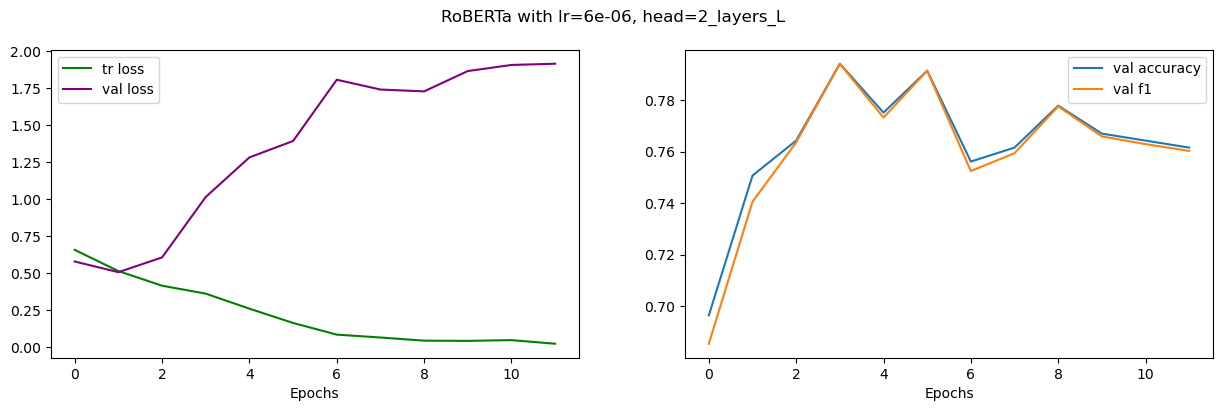

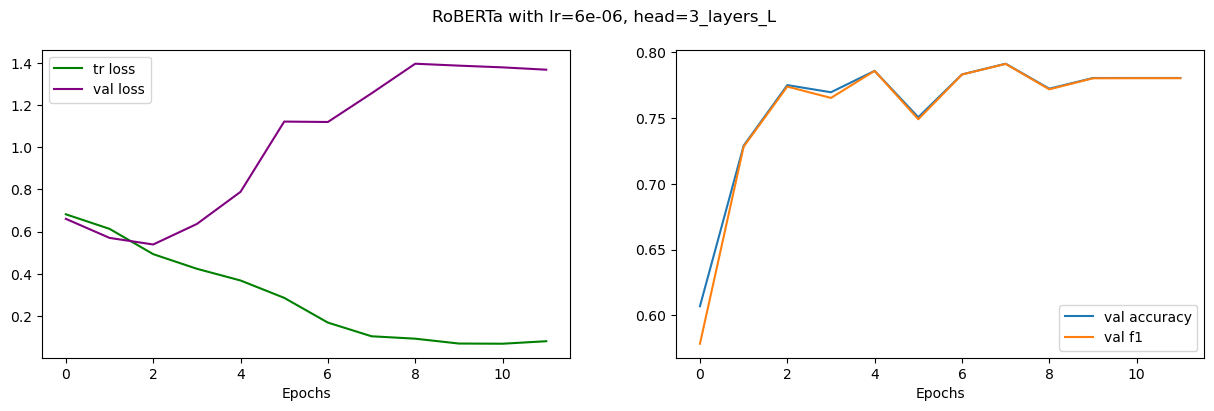

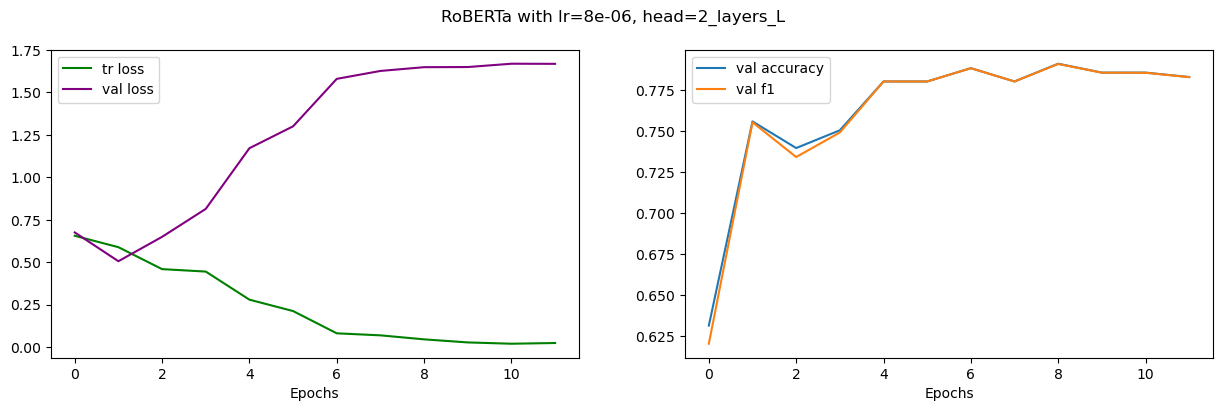

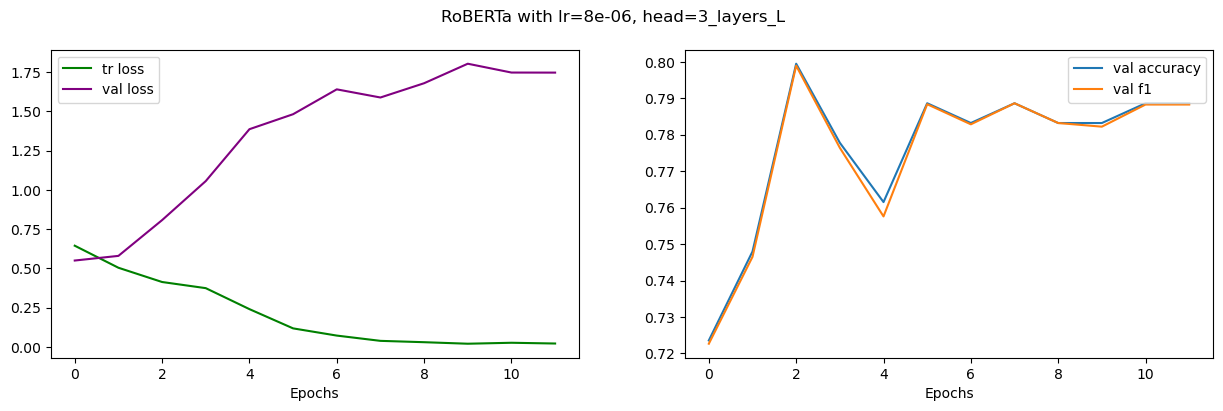

In [31]:
save_folder_pth = './checkpoints_roberta_subtaskA/28_4_2023-3.0' # Grid search run to analyze TO CHANGE


best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_head_{}'.format(lr, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'RoBERTa with lr={}, head={}'.format(lr, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'roberta_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()

In [32]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

RoBERTa with lr=6e-06, head=2_layers_L at epoch 3, F1: 0.7940
RoBERTa with lr=6e-06, head=3_layers_L at epoch 7, F1: 0.7912
RoBERTa with lr=8e-06, head=2_layers_L at epoch 8, F1: 0.7912
RoBERTa with lr=8e-06, head=3_layers_L at epoch 2, F1: 0.7989


## Choose and predict on test with best model

Best model is: RoBERTa with lr=8e-06, head=3_layers_L at epoch 2, F1: 0.7989

In [33]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [34]:
final_model_pth = './checkpoints_roberta_subtaskA/28_4_2023-3.0/lr8e-06_head_3_layers_L/roberta_clf_2.pt'

# Recover the best head configuration
head_3_layers_L = nn.Sequential(
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 2),
                )
# Initialize and recover model checkpoint
final_model = RoBertaClassifier(head=head_3_layers_L)
final_model.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

final_model.to(device)

# Prediction on test
test_preds = test_clf(final_model, test_dataloader, device)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 

Generate result CSV

In [36]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_roberta_submission.csv', index=False)

**RESULTS FROM KAGGLE:**

On the 30% available hidden test set it scores **0.82938**  F1 macro averaged